**ML Challenge** 

    Find an interesting dataset (you can also use the Boston housing dataset as discussed in the lecture) or look around (see e.g. kaggle.com) to perform regression on.

Alright - here I'll load in the Boston housing dataset from https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data.

In [222]:
import pandas as pd

data = pd.read_csv("boston.csv")
data.shape

(506, 14)

OK. So we have 14 variables, 1 is the truth and is called "MEDV". From the website we can read that 

input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

Let's try to plot the data and get a feeling for what we're dealing with.

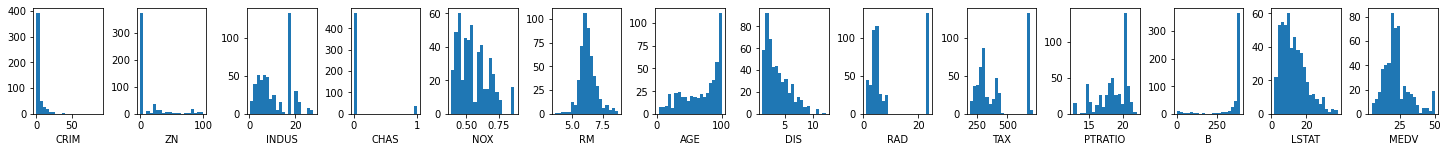

In [223]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 14, constrained_layout=True, figsize = (20,2))
c = 0
for column in data.columns:
    ax[c].hist(data[column], bins = 20)
    ax[c].set_xlabel(column)
    c = c + 1


OK. So the data will require some preprocessing before we can use neural networks to regress "MEDV", because the values are not normally distributed around 0. Let's first divide the set into a training set, and a validation set.

In [224]:
from sklearn.model_selection import train_test_split
data_train, data_validate = train_test_split(data, test_size=0.30, random_state=42)
print(data_train.shape, data_validate.shape)

(354, 14) (152, 14)


Alright - so now we have 354 training examples and 152 validation examples. Let's now preprocess the data using a scaler from sklearn. You could also you techniques from earlier in the course, but here I opt for the "RobustScaler" from sklearn. It substracts the median and scales the data via the interquantile range. To avoid data leakage, we fit the scaler only to the training data. (If we fitted the scaler to the entire dataset, the data in the validation set would impact the median and interquantile range - this is called "data leakage" / "truth leakage").

In [225]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

scaler = RobustScaler().fit(data_train)
data_train_transformed = pd.DataFrame(scaler.transform(data_train), columns = data.columns)
data_validate_transformed = pd.DataFrame(scaler.transform(data_validate), columns = data.columns)

Let's now try to plot the transformed data

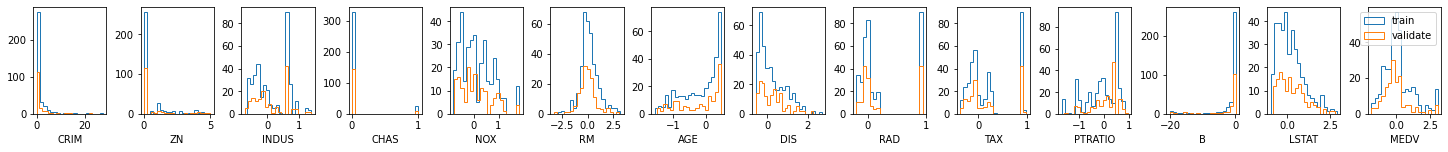

In [226]:
fig, ax = plt.subplots(1, 14, constrained_layout=True, figsize = (20,2))
c = 0
for column in data.columns:
    data_train_transformed[column]
    ax[c].hist(data_train_transformed[column], bins = 20, label = 'train', histtype = 'step')
    ax[c].hist(data_validate_transformed[column], bins = 20, label = 'validate', histtype = 'step')
    ax[c].set_xlabel(column)
    c = c + 1
plt.legend()

    1.b) Train different regressors (linear, BDT, NN) to predict the value of interest given the inputs.

Let's start by making sure we don't make a classic mistake; giving the truth as input to the regressor (this is cheating). To avoid this mistake, we define "input_columns" and "truth_column" and make sure that the truth column is not in the input columns.

In [227]:
input_columns = data.columns.drop('MEDV')
truth_column = 'MEDV'

Now I define an inverse transformation of the truth variable "MEDV", so we can plot results later in the right units. Also, I define a function "plot_residual" that visualizes the predictions.

In [228]:
def inverse_transform_truth(scaler, array):
    return array*scaler.scale_[13]+scaler.center_[13]
def plot_residual(truth, prediction):
    bins = 20
    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize = (10,2.5))
    ax[0].hist(truth, histtype = 'step', bins = bins, label = 'truth')
    ax[0].hist(inverse_transform_truth(scaler,prediction), histtype = 'step', bins = bins, label = 'prediction')
    ax[0].set_xlabel('MDEV')
    ax[1].hist((truth-inverse_transform_truth(scaler,prediction))/truth * 100, histtype = 'step', bins = bins)
    ax[1].set_xlabel('Residual [%]')
    ax[0].legend()
    ax[2].hist2d(inverse_transform_truth(scaler,prediction), truth, bins = 30, cmap = 'magma')
    ax[2].set_xlabel('Prediction')
    ax[2].plot(truth, truth, color = 'grey', ls = '--')
    ax[2].set_ylabel('Truth')
    return


OK. Let's now trail a NN from sklearn and plot the results.

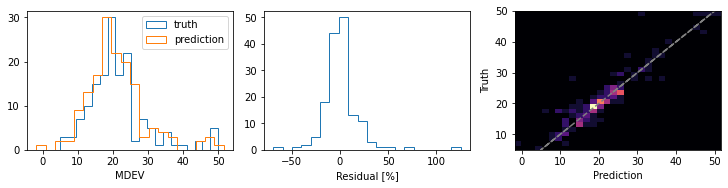

In [229]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42, max_iter=50000, learning_rate = 'adaptive', hidden_layer_sizes = 1000).fit(data_train_transformed[input_columns], data_train_transformed[truth_column])
y_predict_mlp = mlp.predict(data_validate_transformed[input_columns])
plot_residual(data_validate['MEDV'], y_predict_mlp)

As seen from the plot to the left, the predictions follow the truth reasonably.. The middle plot shows the distribution of percentage error - here it's evident that many predictions have an error within +/- 10% of the truth. The third plot shows the truth vs the predictions; ideally the 2D histogram should follow the grey line. However, we only see reasonable agreement in the 10 - 30 range. 

Let's now try to train a decision tree regressor!

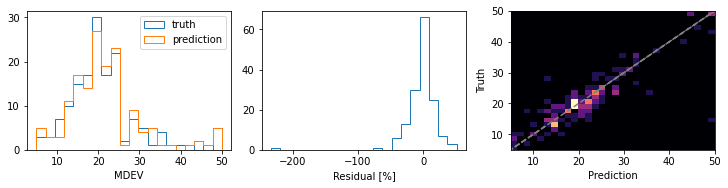

In [230]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(data_train_transformed[input_columns], data_train_transformed[truth_column])
y_predict_tree = clf.predict(data_validate_transformed[input_columns])
plot_residual(data_validate['MEDV'], y_predict_tree)

Let's try a linear regressor:

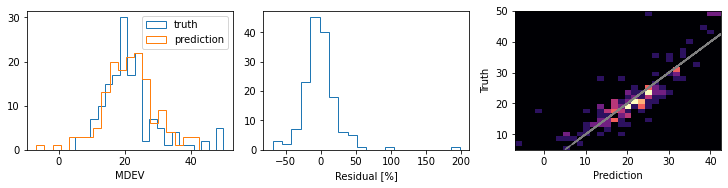

In [231]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(data_train_transformed[input_columns], data_train_transformed[truth_column])
y_predict_linear = lin_reg.predict(data_validate_transformed[input_columns])
plot_residual(data_validate['MEDV'], y_predict_linear)

And let's try a more sophisticated decision tree algorithm called XGBoost:

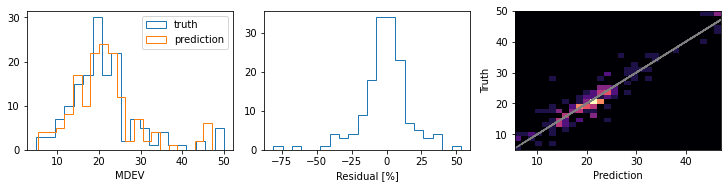

In [232]:
#!pip install xgboost
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(data_train_transformed[input_columns], data_train_transformed[truth_column])
y_predict_xgboost = model.predict(data_validate_transformed[input_columns])
plot_residual(data_validate['MEDV'], y_predict_xgboost)

Let's now transform the truth and prediction back to it's original values, and compare the four methods. 

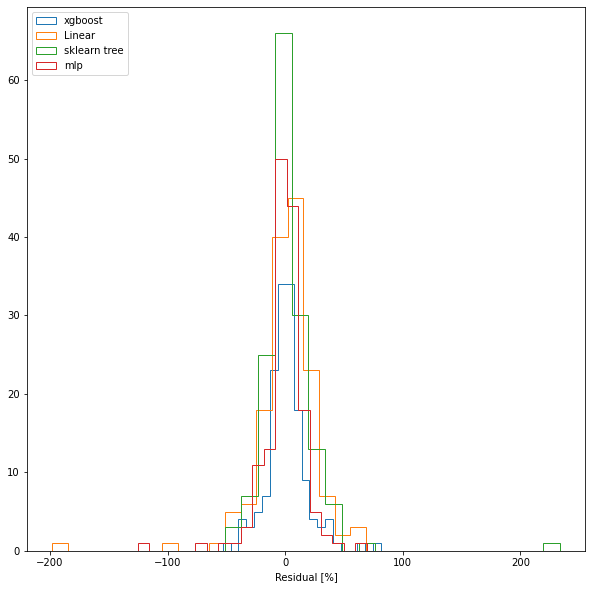

In [233]:
y_predict_xgboost = inverse_transform_truth(scaler,y_predict_xgboost)
y_predict_linear = inverse_transform_truth(scaler,y_predict_linear)
y_predict_tree = inverse_transform_truth(scaler,y_predict_tree)
y_predict_mlp = inverse_transform_truth(scaler,y_predict_mlp)

fig = plt.figure(figsize = (10,10))
bins = 20
plt.hist((y_predict_xgboost - data_validate[truth_column])/data_validate[truth_column] *100, histtype = 'step', label = 'xgboost', bins = bins)
plt.hist((y_predict_linear - data_validate[truth_column])/data_validate[truth_column] *100, histtype = 'step', label = 'Linear', bins = bins)
plt.hist((y_predict_tree - data_validate[truth_column])/data_validate[truth_column] *100, histtype = 'step', label = 'sklearn tree', bins = bins)
plt.hist((y_predict_mlp - data_validate[truth_column])/data_validate[truth_column] *100, histtype = 'step', label = 'mlp', bins = bins)
plt.xlabel('Residual [%]')
plt.legend()

    1.B) What happens if you use different loss functions? For example MSE vs MAE loss?

Models used here doesn't allow for custom loss functions. (Technically XGBoost does, but it's a bit involved.)



    1.C) What happens if you input values that are far outside of the range of the training set (extrapolation) for different regressors?

Let's try to answer this question by scaling the input features of the validation examples by 5, 10 and 30 times their mean, and see what the predictions look like for XGBoost and MLPRegressor

No handles with labels found to put in legend.


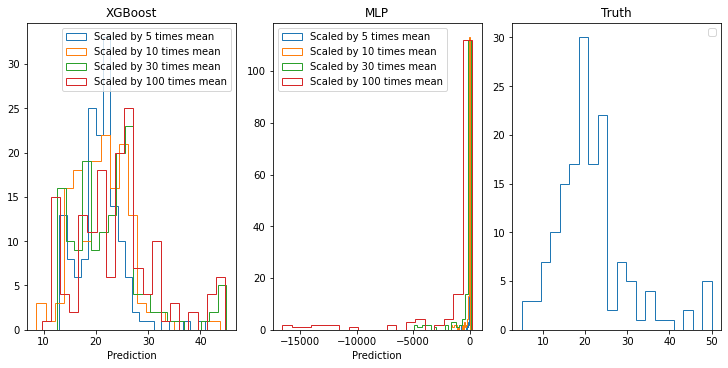

In [245]:
means = data_validate_transformed[input_columns].mean(axis = 0)
fig, ax = plt.subplots(1,3, figsize = (10,5), constrained_layout = True)
bins = 20
for k in [5,10,30,100]:
    scaled_data = data_validate_transformed[input_columns]*means*k
    y_predict_xgboost_scaled = model.predict(scaled_data)
    y_predict_mlp = mlp.predict(scaled_data)
    ax[0].hist(inverse_transform_truth(scaler,y_predict_xgboost_scaled), histtype = 'step', bins = bins, label = f'Scaled by {k} times mean')
    ax[0].set_xlabel('Prediction')
    ax[0].set_title('XGBoost')
    ax[0].legend()
    ax[1].hist(inverse_transform_truth(scaler,y_predict_mlp), histtype = 'step', bins = bins, label = f'Scaled by {k} times mean')
    ax[1].set_xlabel('Prediction')
    ax[1].set_title('MLP')
    ax[1].legend()
ax[2].hist(data_validate[truth_column], histtype = 'step', bins = bins)
ax[2].set_title('Truth')
ax[2].legend()

XGBoost seem quite robust to the scaling, whereas the MLP seems very sensitive (negative price estimation makes no sense). 